# PlantCV processing of binary masks in a time series
Joseph Cristiano 2025
This notebook demonstrates the part of the Hydromaize image processing pipeline that uses PlantCV to process the Binary images generated by `process_COCO_ with_sam_video_v2.py` 

The below code block is our setup. in which we import plantCV and other Libraries that we will use to process the images and masks. Here are the key assumptions: 
- `image_dir` is the directory where the original images are contained
- `mask_dir` is the diretory where the binary masks are contained

In [1]:
!pip install plantcv

In [16]:
from plantcv import plantcv as pcv
from plantcv.parallel import WorkflowInputs
import matplotlib.pyplot as plt
import os 
from tqdm import tqdm
from pprint import pprint
print(os.getcwd())
image_dir = "/work/growth_chamber/images"
mask_dir = "/work/growth_chamber/v4_segmentations"

/


In the cell below we `import glob` and use it to find all matching the prefix and naming scheme of the images in the image directory. This will return an iterable list of of the image file paths. 

In [17]:
import glob
# Define the naming scheme
naming_scheme = os.path.join(image_dir, "topview_*.jpg")
# Get all file names that match the naming scheme
image_filenames = glob.glob(naming_scheme)

print(len(image_filenames))       


1276


The code block below is describing a plantCV workflow. Essentially describing the list of parameters that plantCV will use to repeat this analysis over and over. When I wrote this code I was using the example of their [topdown Arabidopsis tutorial](https://github.com/danforthcenter/plantcv-tutorial-arabidopsis-tray/blob/main/index.ipynb)

But for more information about how this works, their [official Doc page is a very good resource](https://plantcv.readthedocs.io/en/stable/parallel_workflow_inputs/) 


In [18]:
# Input/output options
args = WorkflowInputs(
    images=image_filenames,    
    names='HydroMAIZE',
    result="topview_results",
    outdir=".",
    writeimg=False,
    # debug="plot",
    sample_label="plant"
    )
# Set debug to the global parameter 
pcv.params.debug = args.debug
# Set plotting size (default = 100)
pcv.params.dpi = 200
# Increase text size and thickness to make labels clearer
# (size may need to be altered based on original image size)
pcv.params.text_size = 10
pcv.params.text_thickness = 20

Now we process all the data!!!

This code block goes through each image captured, finds each of the 20 mask files in the mask directory, and then does the shape analysis for each of the 20 masks. This is made easy because the mask files are named after the image file that they correspond to, with a "_<plant_id>" suffix at the end of the file name. This makes it as simple as extracting `plant_id` with the line `plant_id = mask_filename.split('/')[-1].split('.')[0].split('_')[-1]`

It should be noted that color analysis COULD be done if there was a color card or some other reference in the frame that we could use as a baseline for color image analysis. Because we don't have that for this run, that code is written but commented out.  

In [19]:
for file in tqdm(image_filenames):
    base_name = file.split('/')[-1].split('.')[0]
    img, path, filename = pcv.readimage(filename=file)
    mask_filename = os.path.join(mask_dir, base_name)
    # print(len(glob.glob(f"{mask_filename}_*.jpg")))
    for mask_file in glob.glob(f"{mask_filename}_*.jpg"):
        # print(f"Processing {file} with mask {mask_file}")
        mask, mask_path, mask_filename = pcv.readimage(filename=mask_file)
        plant_id = mask_filename.split('/')[-1].split('.')[0].split('_')[-1]
        # print(f"{base_name}_plant{plant_id}")
        shape_img = pcv.analyze.size(
            img=img, 
            labeled_mask=mask,
            label= f"{base_name}_{plant_id}",
            n_labels=1)
        # colo_img = pcv.analyze.color(rgb_img=img,
        #     labeled_mask=mask,
        #     n_labels=1,
        #     label= f"{base_name}_{plant_id}", 
        #     colorspaces="HSV"
        #     )
pcv.outputs.save_results(filename='/work/growth_chamber/pcv_output.json')

100%|██████████████████████████████| 1276/1276 [1:05:54<00:00,  3.10s/it]


This last block is here to export the data into a CSV os that we can move it to the biostats notebooks

In [20]:
import pandas as pd 
import re 

# First, let's see what observation keys actually look like
print("Sample observation keys:")
for i, key in enumerate(list(pcv.outputs.observations.keys())[:5]):
    print(f"  {key}")
 
rows = []
for i in pcv.outputs.observations.keys():
    match = re.search(r"topview_(\d{4}-\d{2}-\d{2}_\d{2}_\d{2}_\d{2})", i)
    time_stamp = match.group(1)
    plant_id = i.split('_')[-2]
    # print(time_stamp,plant_id)
    obs_data = {k: v["value"] for k, v in pcv.outputs.observations[i].items()}
    # Convert to datetime
    rows.append({
        "timestamp" : pd.to_datetime(time_stamp, format="%Y-%m-%d_%H_%M_%S"),
        "plant_id": plant_id,
        **obs_data 
    })

df = pd.DataFrame(rows)
pprint(df.head())


df.to_csv('/work/growth_chamber/pcv_data_frame.csv')                                                    

Sample observation keys:
  topview_2024-08-06_11_15_01_8_1
  topview_2024-08-06_11_15_01_9_1
  topview_2024-08-06_11_15_01_3_1
  topview_2024-08-06_11_15_01_13_1
  topview_2024-08-06_11_15_01_1_1
            timestamp plant_id  in_bounds    area  convex_hull_area  solidity  \
0 2024-08-06 11:15:01        8       True  1405.0          182741.5  0.007688   
1 2024-08-06 11:15:01        9       True  1799.0          239785.5  0.007503   
2 2024-08-06 11:15:01        3       True  2134.0          286871.5  0.007439   
3 2024-08-06 11:15:01       13       True  1859.0          147937.0  0.012566   
4 2024-08-06 11:15:01        1      False  2122.0          277285.5  0.007653   

       perimeter  total_edge_length  width  height  longest_path  \
0   85556.673603        1500.268237    528     480    548.639226   
1  114459.787256        1989.779992    655     600    627.034289   
2  145846.558862        2405.811517    704     656    671.607772   
3  101149.177242        2129.561736    512   

The following Blocks are the first few steps of the Biostat notebooks but are good for debugging and visualizing whether or not the pipeline is working properly. 

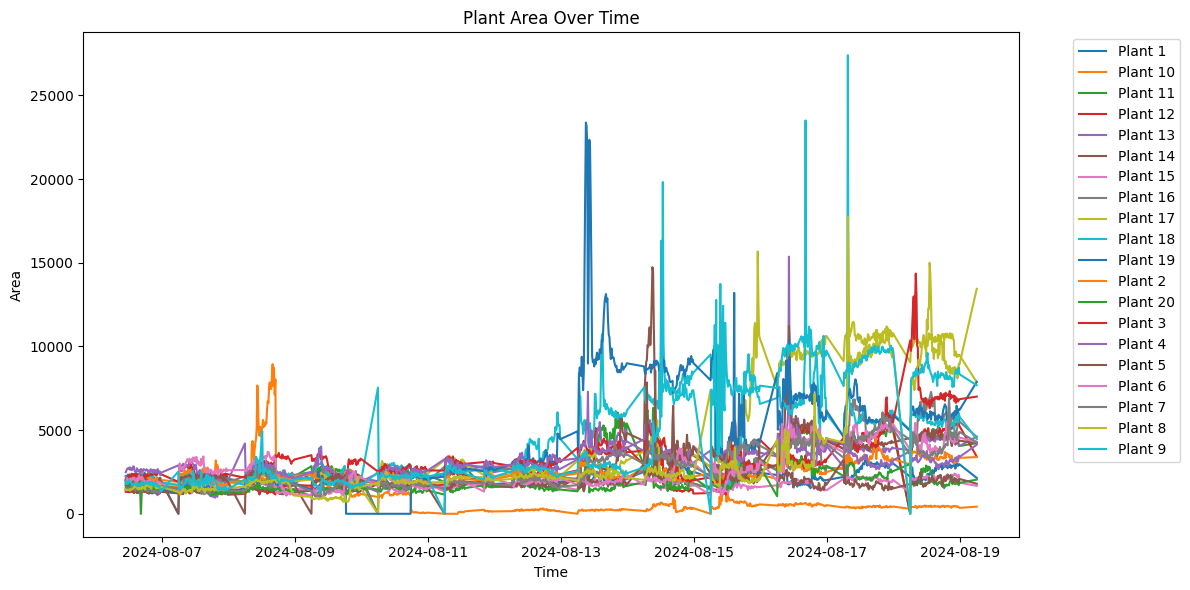

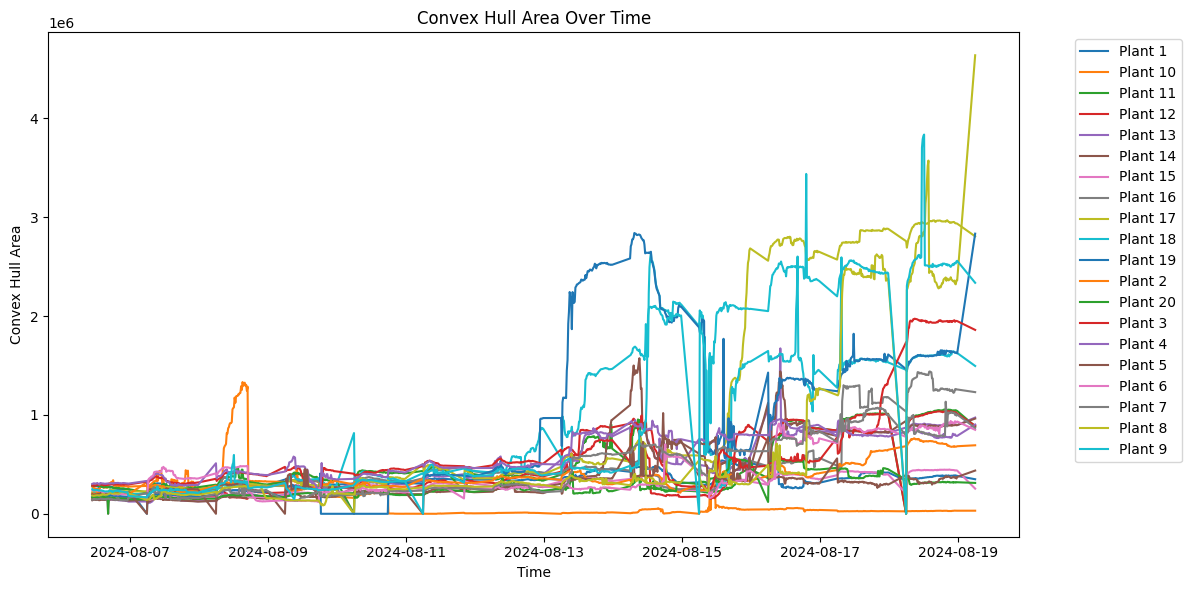

In [21]:
import matplotlib.pyplot as plt

# Make sure timestamp column is datetime
df["timestamp"] = pd.to_datetime(df["timestamp"])

# Sort by plant and time (just in case)
df = df.sort_values(["plant_id", "timestamp"])

# Plot area over time for each plant
plt.figure(figsize=(12,6))
for plant_id, group in df.groupby("plant_id"):
    plt.plot(group["timestamp"], group["area"], label=f"Plant {plant_id}")
plt.xlabel("Time")
plt.ylabel("Area")
plt.title("Plant Area Over Time")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# Plot convex_hull_area over time for each plant
plt.figure(figsize=(12,6))
for plant_id, group in df.groupby("plant_id"):
    plt.plot(group["timestamp"], group["convex_hull_area"], label=f"Plant {plant_id}")
plt.xlabel("Time")
plt.ylabel("Convex Hull Area")
plt.title("Convex Hull Area Over Time")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


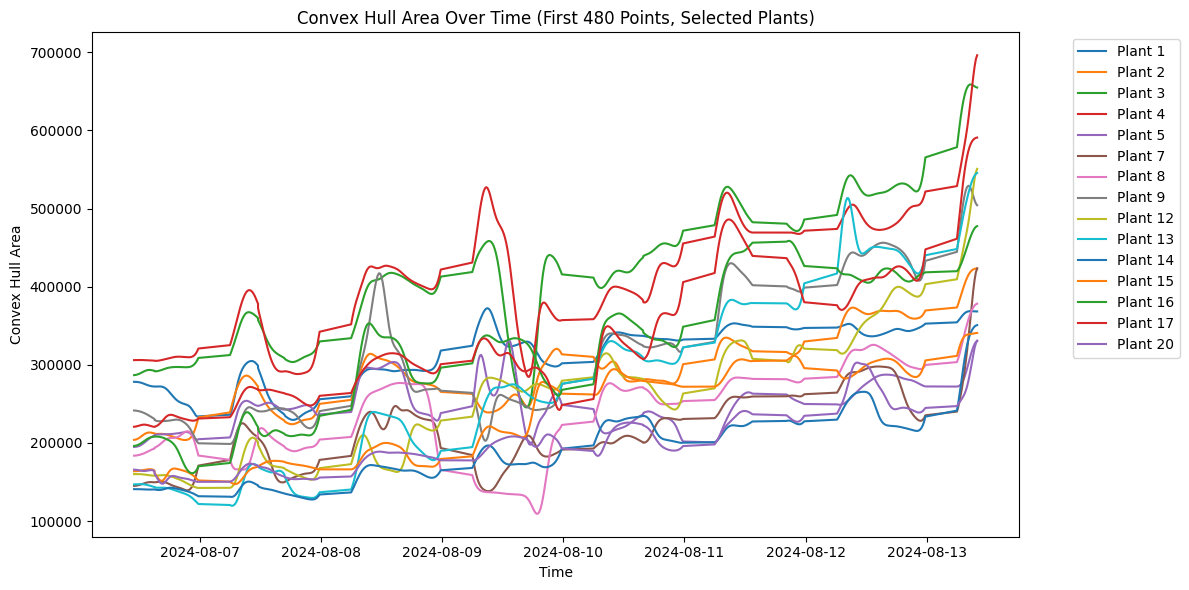

In [22]:
from scipy.ndimage import gaussian_filter1d
# Exclude unwanted plants
# exclude_plants = { 4, 6, 7, 10,12, 17,18, 19}
exclude_plants = {6,10,11,18,19}
df["plant_id"] = df["plant_id"].astype(int)
df_filtered = df[~df["plant_id"].isin(exclude_plants)]

# Keep only the first 480 time points overall
df_filtered = (
    df_filtered.sort_values("timestamp")
    .groupby("plant_id")
    .head(480)
)



# Plot convex_hull_area over time
plt.figure(figsize=(12,6))
for plant_id, group in df_filtered.groupby("plant_id"):
    smoothed = gaussian_filter1d(group["convex_hull_area"].values, sigma=4)
    df_filtered.loc[group.index, "convex_hull_area_smoothed"] = smoothed
    plt.plot(group["timestamp"], smoothed, label=f"Plant {plant_id}")

plt.xlabel("Time")
plt.ylabel("Convex Hull Area")
plt.title("Convex Hull Area Over Time (First 480 Points, Selected Plants)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()